In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/binaryclassificationwithabankchurndataset/sample_submission.csv
/kaggle/input/binaryclassificationwithabankchurndataset/train.csv
/kaggle/input/binaryclassificationwithabankchurndataset/test.csv


# Imports and setups

In [2]:
!pip install catboost

In [3]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration and Loading

In [4]:
df = pd.read_csv('/kaggle/input/binaryclassificationwithabankchurndataset/train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15702656.0,Nwora,567.0,France,Male,33.0,9.0,0.0,2.0,1.0,0.0,156792.89,0.0
1,1,15647965.0,Yevdokimova,628.0,France,Female,38.0,3.0,0.0,1.0,1.0,1.0,51987.99,1.0
2,2,15798834.0,Ch'iu,635.0,France,Female,29.0,3.0,0.0,2.0,1.0,1.0,113079.19,0.0
3,3,15672056.0,Hsia,681.0,France,Male,28.0,6.0,0.0,2.0,1.0,0.0,14081.64,0.0
4,4,15759537.0,Okwudilichukwu,587.0,France,Female,27.0,5.0,0.0,2.0,1.0,0.0,158958.90,0.0


In [5]:
df.shape

(15000, 14)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [7]:
df.describe()


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.579454e+07,657.856800,37.710133,5.018667,42338.107539,1.590533,0.779133,0.496000,116944.059867,0.198467
std,4330.271354,1.268495e+07,72.678739,8.144880,2.787407,59703.047751,0.525822,0.414845,0.500001,46047.485455,0.398859
min,0.000000,1.567151e+05,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563435e+07,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82644.332500,0.000000
50%,7499.500000,1.568947e+07,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,122449.420000,0.000000
75%,11249.250000,1.575682e+07,707.000000,42.000000,7.000000,109636.342500,2.000000,1.000000,1.000000,155703.022500,0.000000
max,14999.000000,1.569172e+09,850.000000,72.000000,10.000000,187911.550000,5.000000,1.000000,1.000000,885120.790000,1.000000


In [8]:
df.corr(numeric_only=True)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,1.000000,-0.013143,0.002450,0.008301,0.010274,0.002993,-0.003234,0.007082,0.012198,0.006161,-0.015533
CustomerId,-0.013143,1.000000,0.014209,-0.001726,-0.005906,-0.005943,0.006489,-0.015185,0.008342,-0.005803,-0.004122
CreditScore,0.002450,0.014209,1.000000,-0.010207,0.005782,0.011393,0.009826,0.000844,0.015396,0.015829,-0.052375
Age,0.008301,-0.001726,-0.010207,1.000000,-0.012750,0.090285,-0.169409,-0.007544,-0.026430,0.004344,0.449425
Tenure,0.010274,-0.005906,0.005782,-0.012750,1.000000,-0.014872,0.016087,0.021382,-0.010231,0.008884,-0.032897
Balance,0.002993,-0.005943,0.011393,0.090285,-0.014872,1.000000,-0.423496,-0.018996,-0.021580,-0.003853,0.160062
NumOfProducts,-0.003234,0.006489,0.009826,-0.169409,0.016087,-0.423496,1.000000,-0.001089,0.047784,0.002612,-0.312812
HasCrCard,0.007082,-0.015185,0.000844,-0.007544,0.021382,-0.018996,-0.001089,1.000000,-0.026277,-0.012787,-0.010670
IsActiveMember,0.012198,0.008342,0.015396,-0.026430,-0.010231,-0.021580,0.047784,-0.026277,1.000000,0.003154,-0.188748
EstimatedSalary,0.006161,-0.005803,0.015829,0.004344,0.008884,-0.003853,0.002612,-0.012787,0.003154,1.000000,0.035193


# Data Cleaning

In [9]:
# keraksiz ustunlarni olib tashlaymiz
df = df.drop(columns=['id', 'CustomerId', 'Surname'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,567.0,France,Male,33.0,9.0,0.0,2.0,1.0,0.0,156792.89,0.0
1,628.0,France,Female,38.0,3.0,0.0,1.0,1.0,1.0,51987.99,1.0
2,635.0,France,Female,29.0,3.0,0.0,2.0,1.0,1.0,113079.19,0.0
3,681.0,France,Male,28.0,6.0,0.0,2.0,1.0,0.0,14081.64,0.0
4,587.0,France,Female,27.0,5.0,0.0,2.0,1.0,0.0,158958.90,0.0


# Visual Data Analysis


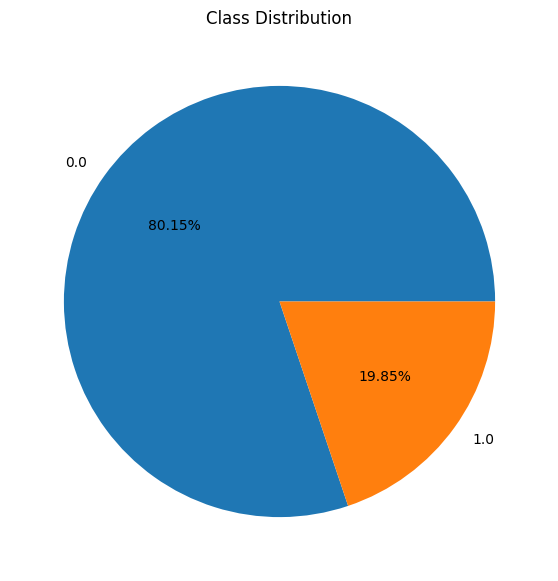

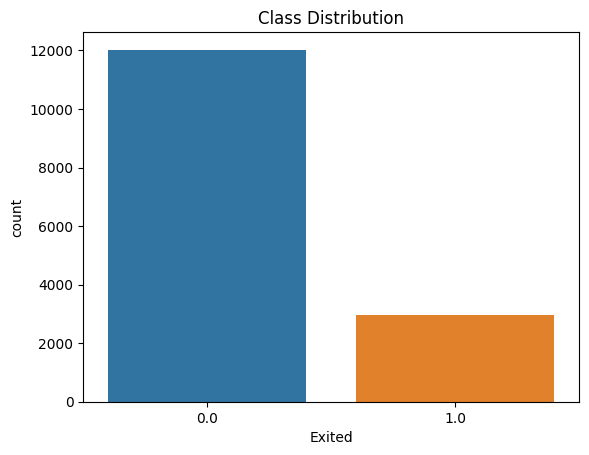

In [10]:
# class distribution
clss_dis = df['Exited'].value_counts()/len(df)*100

#plotting
plt.figure(figsize=(7,7))
plt.pie(clss_dis, labels=clss_dis.index, autopct='%1.2f%%')

plt.title('Class Distribution')
plt.show()

sns.countplot(x='Exited', data=df)
plt.title('Class Distribution')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

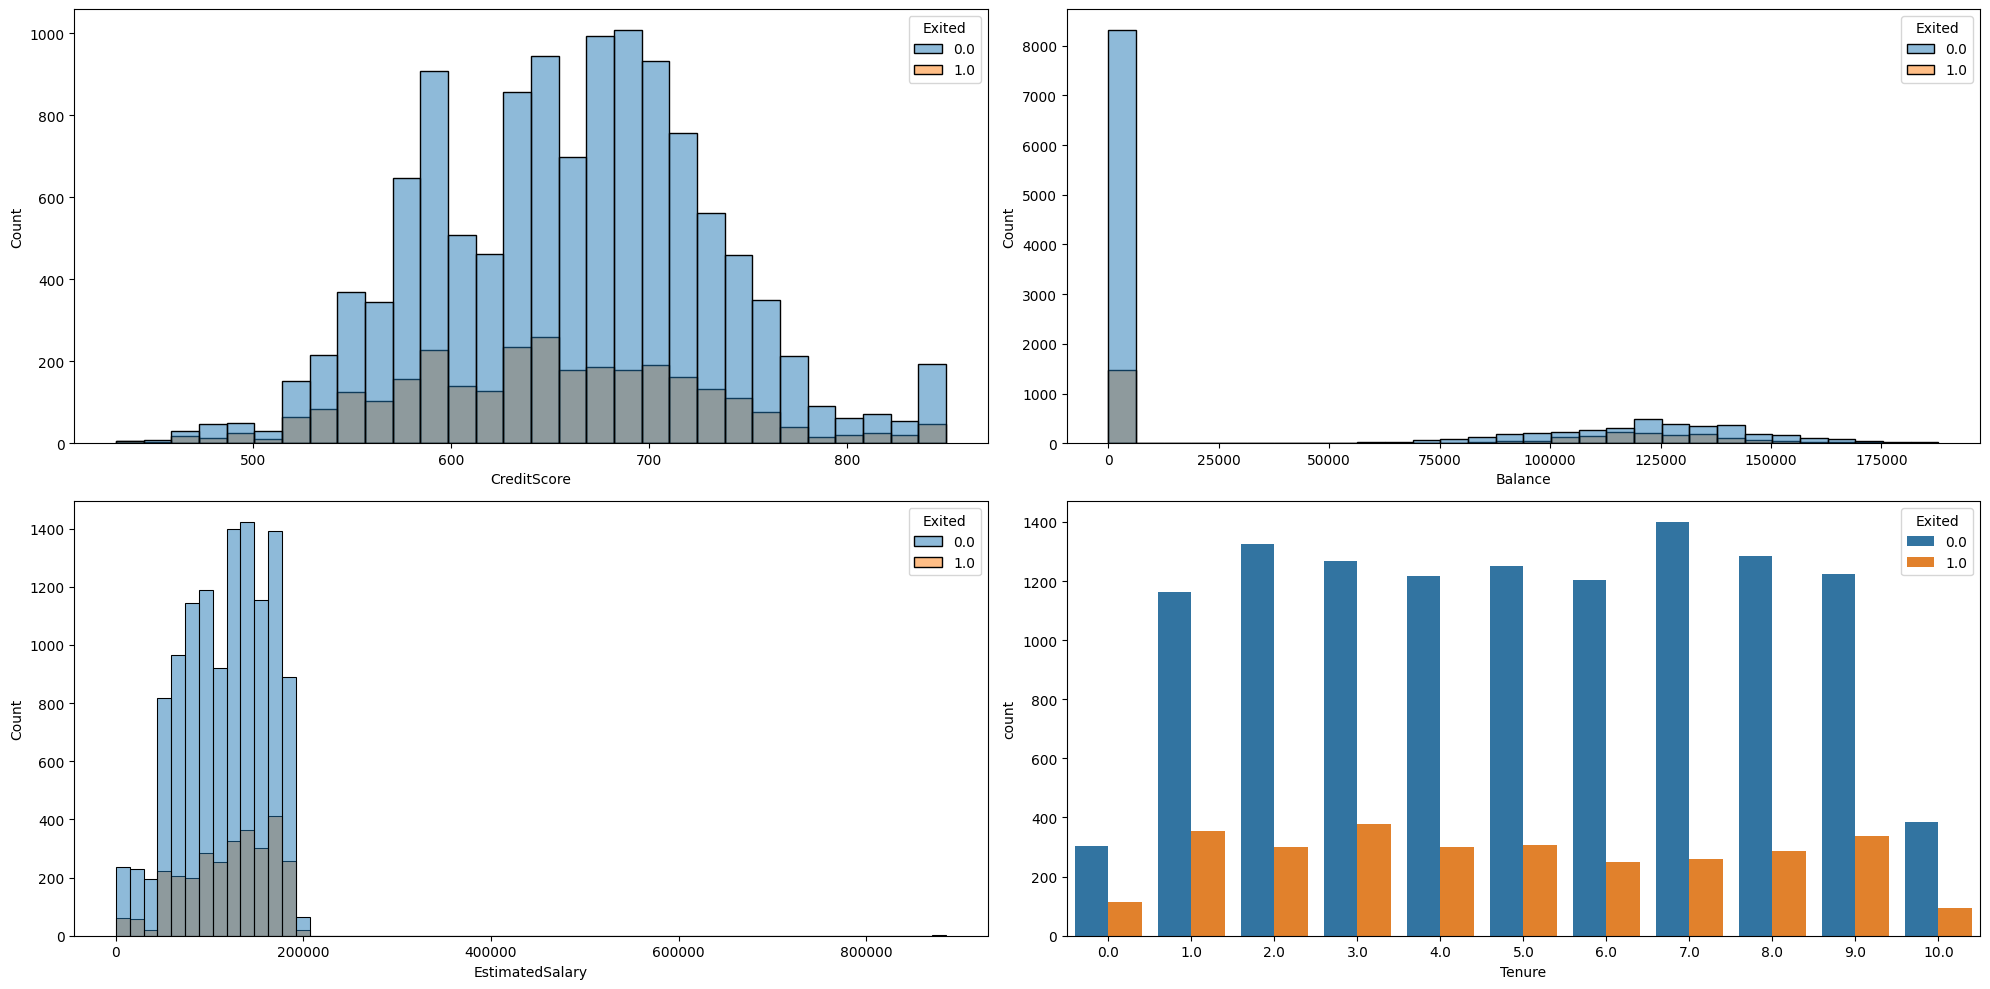

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.histplot(x='CreditScore', bins=30, data=df, hue='Exited', ax=ax[0, 0])
sns.histplot(x='Balance', data=df, bins=30, hue='Exited', ax=ax[0, 1])
sns.histplot(x='EstimatedSalary', bins=60, data=df, hue='Exited', ax=ax[1, 0])

sns.countplot(x='Tenure', data=df, hue='Exited', ax=ax[1, 1])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

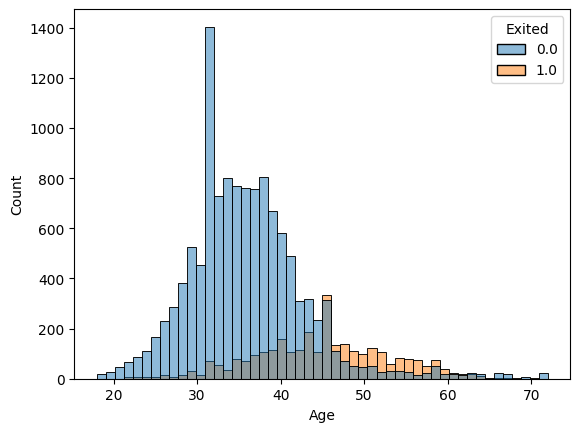

In [12]:
sns.histplot(x='Age', bins=50, data=df, hue='Exited')
plt.show()

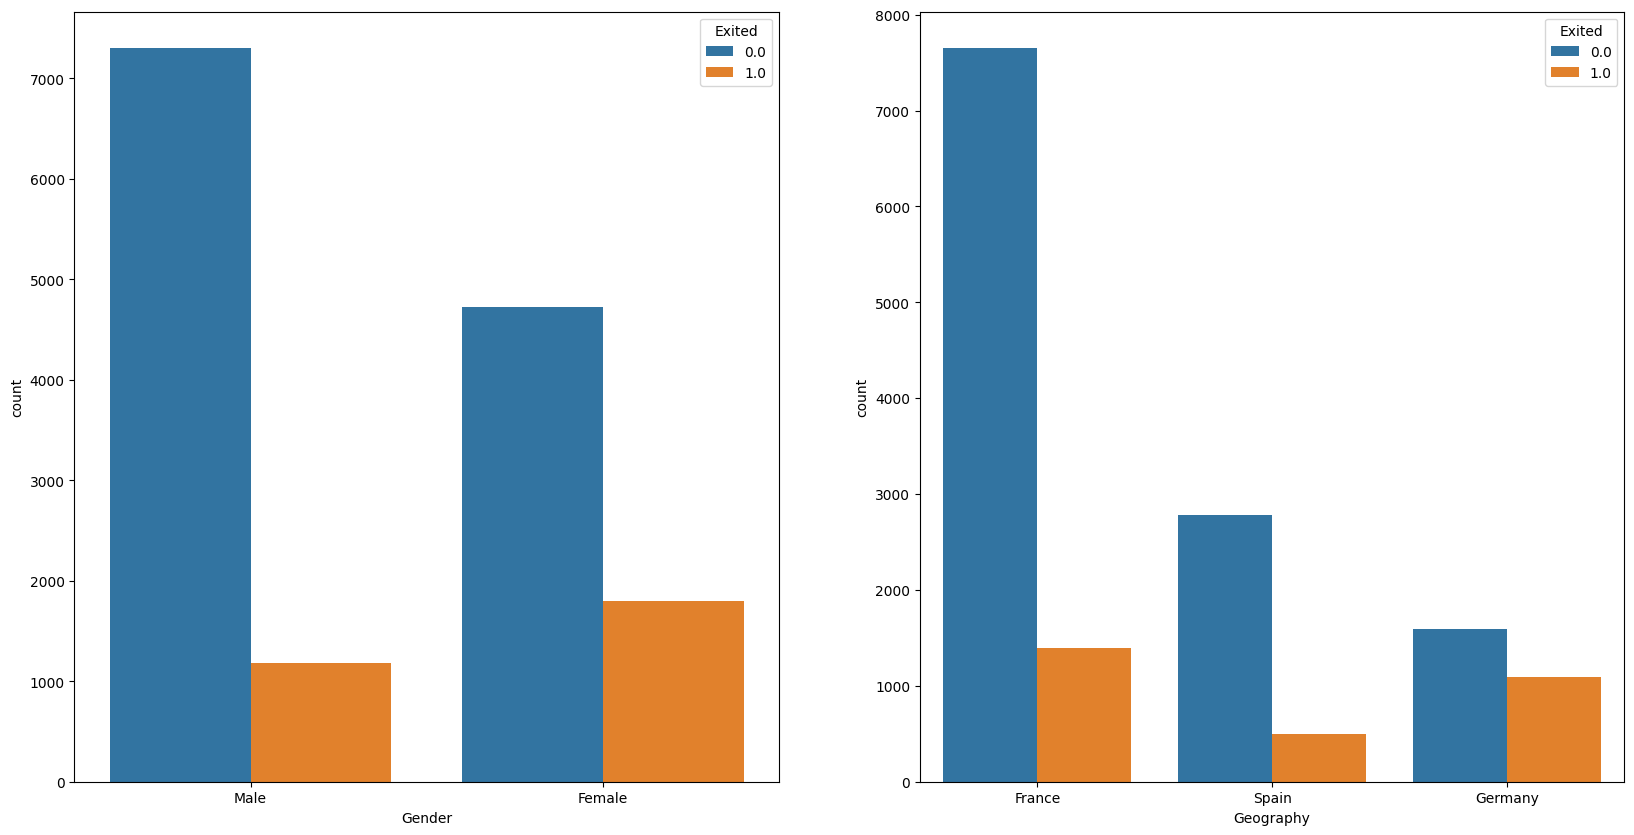

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(x='Gender', hue='Exited', data=df, ax=ax[0])
sns.countplot(x='Geography', hue='Exited', data=df, ax=ax[1])
plt.show()

# Data Preprocessing


In [14]:
# Kategoriyali va raqamli ustunlarni ajratish
 
categorical_columns = ['Gender', 'Geography'] 
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'] 
target = 'Exited' 

In [15]:
X = df[categorical_columns + numerical_columns]
y = df[target]

In [16]:
# Ma'lumotlarni o‘qitish va test to‘plamlariga bo‘lish
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modelling

In [17]:
# CatBoostClassifier modelini yaratish
model = CatBoostClassifier(
    iterations=1000,              
    learning_rate=0.05,           
    depth=6,                     
    l2_leaf_reg=3,                
    auto_class_weights='Balanced',   
    cat_features=categorical_columns,   
    eval_metric='AUC',            
    early_stopping_rounds=50,     
    task_type='GPU',              
    verbose=100,                  
    random_seed=42               
)

In [18]:
# Modelni o‘qitish
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),    
    use_best_model=True         
)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9036894	best: 0.9036894 (0)	total: 180ms	remaining: 3m
100:	test: 0.9334129	best: 0.9334129 (100)	total: 3.57s	remaining: 31.8s
bestTest = 0.9339820743
bestIteration = 136
Shrink model to first 137 iterations.


In [19]:
# Bashorat qilish
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [20]:
# 7. Natijalarni baholash
print("AUC Skori:", roc_auc_score(y_test, y_pred_proba))
print("Aniqlik (Accuracy):", accuracy_score(y_test, y_pred))
print("\nBaholash hisoboti:\n", classification_report(y_test, y_pred))

AUC Skori: 0.9339820751585457
Aniqlik (Accuracy): 0.8566666666666667

Baholash hisoboti:
               precision    recall  f1-score   support

         0.0       0.96      0.85      0.91      2405
         1.0       0.59      0.87      0.71       595

    accuracy                           0.86      3000
   macro avg       0.78      0.86      0.81      3000
weighted avg       0.89      0.86      0.87      3000



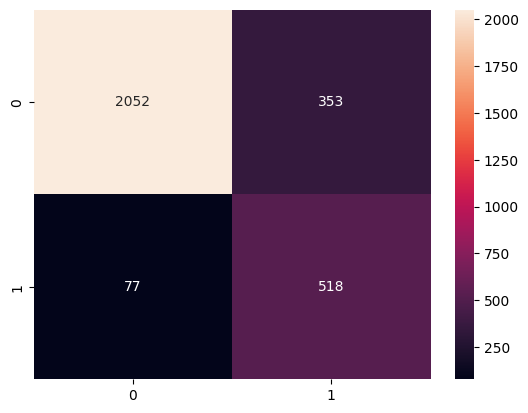

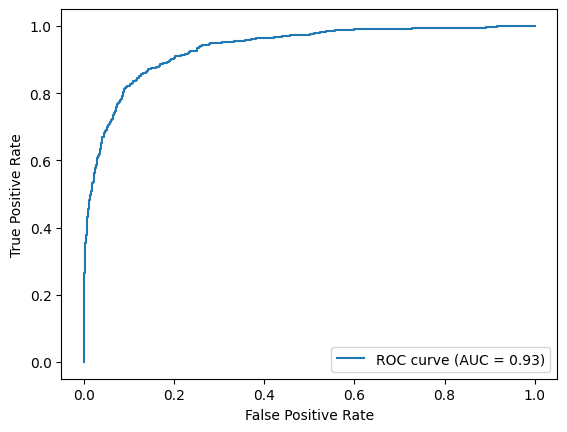

In [21]:
# confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

In [22]:
# Eng muhim xususiyatlarni chiqarish
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)
print("\nXususiyatlarning ahamiyati:\n", feature_importance)


Xususiyatlarning ahamiyati:
            Feature  Importance
6    NumOfProducts   45.965991
3              Age   24.056933
8   IsActiveMember    7.585653
5          Balance    7.216023
1        Geography    6.698680
0           Gender    3.661384
2      CreditScore    2.026854
9  EstimatedSalary    1.687300
4           Tenure    1.040145
7        HasCrCard    0.061036


# Test_set and Submission

In [23]:
df1 = pd.read_csv("/kaggle/input/binaryclassificationwithabankchurndataset/test.csv")
df1.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15732563.0,Hs?,707.0,Germany,Male,21.0,4.0,114513.66,2.0,1.0,0.0,176692.87
1,15001,15727041.0,Ma,678.0,Germany,Male,33.0,5.0,142510.50,1.0,0.0,0.0,52820.13
2,15002,15753679.0,K?,636.0,Spain,Male,45.0,9.0,0.00,2.0,1.0,1.0,125062.02
3,15003,15581554.0,H?,697.0,Spain,Male,46.0,8.0,0.00,2.0,1.0,0.0,131647.41
4,15004,15773723.0,Bellucci,553.0,Spain,Male,31.0,2.0,0.00,2.0,1.0,0.0,58814.41


In [24]:
# id ustunini saqlab qo'yish
t_ids = df1['id']
t_ids.head()

0    15000
1    15001
2    15002
3    15003
4    15004
Name: id, dtype: int64

In [25]:
# keraksiz ustunlarni olib tashlaymiz
df1 = df1.drop(columns=['id', 'CustomerId', 'Surname'])
df1.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,707.0,Germany,Male,21.0,4.0,114513.66,2.0,1.0,0.0,176692.87
1,678.0,Germany,Male,33.0,5.0,142510.50,1.0,0.0,0.0,52820.13
2,636.0,Spain,Male,45.0,9.0,0.00,2.0,1.0,1.0,125062.02
3,697.0,Spain,Male,46.0,8.0,0.00,2.0,1.0,0.0,131647.41
4,553.0,Spain,Male,31.0,2.0,0.00,2.0,1.0,0.0,58814.41


In [26]:
categorical_columns = ['Gender', 'Geography'] 
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

In [27]:
X = df1[categorical_columns + numerical_columns]

In [28]:
y_prediction = model.predict(X)  
y_prediction_proba = model.predict_proba(X)[:, 1] 

In [29]:
y_prediction_proba

array([0.11347342, 0.45974046, 0.16662782, ..., 0.99705614, 0.02038934,
       0.53164225])

In [30]:
# Submission DataFrame yaratish
submission = pd.DataFrame({
    'id': t_ids,
    'Exited': y_prediction_proba
})

# CSV faylga saqlash
submission.to_csv('submission.csv', index=False)
print("Submission fayli tayyor: submission.csv")

Submission fayli tayyor: submission.csv
